In [3]:
import os
# Keep using keras-2 (tf-keras) rather than keras-3 (keras).
os.environ['TF_USE_LEGACY_KERAS'] = '1'

In [19]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import base64
import imageio
import io
import matplotlib
import matplotlib.pyplot as plt
import os
import shutil
import tempfile
import tensorflow as tf
import zipfile
import IPython
import PIL
from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import q_network
from tf_agents.policies import policy_saver
from tf_agents.policies import py_tf_eager_policy
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common

files = None
tempdir = os.getenv("TEST_TMPDIR", tempfile.gettempdir())

In [20]:
import xvfbwrapper
xvfbwrapper.Xvfb(1400, 900, 24).start()

#import pyvirtualdisplay
#display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

In [21]:
tf.version.VERSION

'2.15.1'

## Hyperparameters

In [22]:
env_name = 'CartPole-v1'

collect_steps_per_iteration = 100
replay_buffer_capacity = 100000

fc_layer_params = (100,)

batch_size = 64
learning_rate = 1e-3
log_interval = 5

num_eval_episodes = 10
eval_interval = 1000

## Creation of Train and Evaluation environment

Environment: CartPole-v1

In [23]:
train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_name)

train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

'-avx512er' is not a recognized feature for this target (ignoring feature)
'-avx512pf' is not a recognized feature for this target (ignoring feature)
'-avx512er' is not a recognized feature for this target (ignoring feature)
'-avx512pf' is not a recognized feature for this target (ignoring feature)
'-avx512er' is not a recognized feature for this target (ignoring feature)
'-avx512pf' is not a recognized feature for this target (ignoring feature)
'-avx512er' is not a recognized feature for this target (ignoring feature)
'-avx512pf' is not a recognized feature for this target (ignoring feature)
'-avx512er' is not a recognized feature for this target (ignoring feature)
'-avx512pf' is not a recognized feature for this target (ignoring feature)
'-avx512er' is not a recognized feature for this target (ignoring feature)
'-avx512pf' is not a recognized feature for this target (ignoring feature)
'-avx512er' is not a recognized feature for this target (ignoring feature)
'-avx512pf' is not a reco

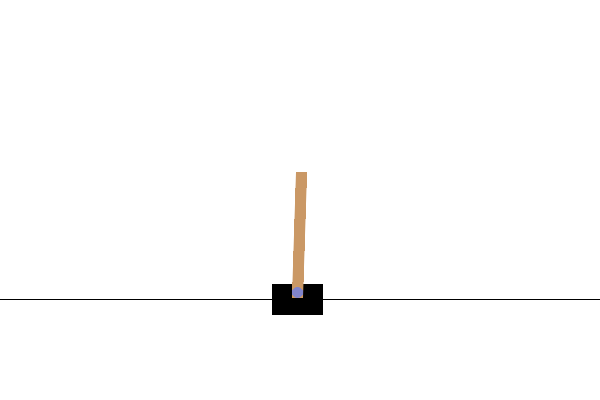

In [24]:
train_py_env.reset()
render=train_py_env.render()
PIL.Image.fromarray(render)

## Initializing of QNetwork, Optimizer, DqnAgent

#### QNetwork represent Q-Function --> Q: S x A -> R
Q-Function(state, action) = reward

#### Adam Optimizer 
Optimizer perform gradiend operation for weights adjustment

#### DqnAgent 
DqnAgent perform all operations needed for take actions on environment based on states and policy, update observer and optimize throug Adam the weights

In [25]:
q_net = q_network.QNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    fc_layer_params=fc_layer_params
)

optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

global_step = tf.compat.v1.train.get_or_create_global_step()

agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_huber_loss,
    train_step_counter=global_step
)

agent.initialize()

## Data Collection
#### Replay Buffer for data store
#### Driver for orchestrate comunication and agent call

In [26]:
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_capacity
)

collect_driver = dynamic_step_driver.DynamicStepDriver(
    train_env,
    agent.collect_policy,
    observers=[replay_buffer.add_batch],
    num_steps=collect_steps_per_iteration
)

collect_driver.run()

dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, sample_batch_size=batch_size, num_steps=2
).prefetch(3)

iterator = iter(dataset)

## Training
#### Following function perform 1 iteration training

In [27]:
agent.train = common.function(agent.train)

def train_one_iteration():
    collect_driver.run()
    
    experience, unused_info = next(iterator)
    train_loss = agent.train(experience)

    iteration = agent.train_step_counter.numpy()
    print(f'iteration: {iteration} loss: {train_loss.loss}')

## Embeds a video into a specified container on the page.

In [28]:
def embed_video(filename):
    video = open(filename, 'rb').read()
    b64 = base64.b64encode(video)

    """Embeds a gif file in the notebook."""
    tag = '''
        <video width="640" height="480" controls>
            <source src="data:video/mp4;base64,{0}" type="video/mp4">
            Your browser does not support the video tag.
        </video>
    '''.format(b64.decode())
    return IPython.display.HTML(tag)

## Run episodes and append video buffer to file

Run 'n' episodes and append env.render() RGB Matrix to file

In [29]:
def run_episodes_and_create_video(policy, eval_tf_env, eval_py_env, num_episodes, filename):
    filename = f'{filename}.mp4'

    with imageio.get_writer(filename, fps=60) as video:
        for _ in range(num_episodes):
            time_step = eval_tf_env.reset()
            video.append_data(eval_py_env.render())

            while not time_step.is_last():
                action_step = policy.action(time_step)
                time_step = eval_tf_env.step(action_step.action)
                video.append_data(eval_py_env.render())
    IPython.display.display(embed_video(filename))

## No Train Behaviour

In [30]:
print(f'global_step: {global_step}')
run_episodes_and_create_video(agent.policy, eval_env, eval_py_env, 3, "no_train")

'-avx512er' is not a recognized feature for this target (ignoring feature)
'-avx512pf' is not a recognized feature for this target (ignoring feature)
'-avx512er' is not a recognized feature for this target (ignoring feature)
'-avx512pf' is not a recognized feature for this target (ignoring feature)
'-avx512er' is not a recognized feature for this target (ignoring feature)
'-avx512pf' is not a recognized feature for this target (ignoring feature)
'-avx512er' is not a recognized feature for this target (ignoring feature)
'-avx512pf' is not a recognized feature for this target (ignoring feature)
'-avx512er' is not a recognized feature for this target (ignoring feature)
'-avx512pf' is not a recognized feature for this target (ignoring feature)
'-avx512er' is not a recognized feature for this target (ignoring feature)
'-avx512pf' is not a recognized feature for this target (ignoring feature)
'-avx512er' is not a recognized feature for this target (ignoring feature)
'-avx512pf' is not a reco

global_step: <tf.Variable 'global_step:0' shape=() dtype=int64, numpy=1>


## 1 Iteration Training

In [31]:
train_one_iteration()
run_episodes_and_create_video(agent.policy, eval_env, eval_py_env, 3, "1_iter_train")

iteration: 2 loss: 0.5058455467224121


#### Checkpointer

In [32]:
checkpoint_dir = os.path.join(tempdir, 'checkpoint')
train_checkpointer = common.Checkpointer(
    ckpt_dir=checkpoint_dir,
    max_to_keep=1,
    agent=agent,
    policy=agent.policy,
    replay_buffer=replay_buffer,
    global_step=global_step
)

#### Policy Saver

In [33]:
policy_dir = os.path.join(tempdir, 'policy')
tf_policy_saver = policy_saver.PolicySaver(agent.policy)

TypeError: this __dict__ descriptor does not support '_DictWrapper' objects

In [ ]:
saved_policy = tf.saved_model.load(policy_dir)
run_episodes_and_create_video(saved_policy, eval_env, eval_py_env)

In [ ]:
def create_zip_file(dirname, base_filename):
  return shutil.make_archive(base_filename, 'zip', dirname)

def upload_and_unzip_file_to(dirname):
  if files is None:
    return
  uploaded = files.upload()
  for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))
    shutil.rmtree(dirname)
    zip_files = zipfile.ZipFile(io.BytesIO(uploaded[fn]), 'r')
    zip_files.extractall(dirname)
    zip_files.close()

In [ ]:
train_checkpointer.save(global_step)
checkpoint_zip_filename = create_zip_file(checkpoint_dir, os.path.join(tempdir, 'exported_cp'))

In [ ]:
if files is not None:
  files.download(checkpoint_zip_filename) # try again if this fails: https://github.com/googlecolab/colabtools/issues/469

In [ ]:
upload_and_unzip_file_to(checkpoint_dir)
train_checkpointer.initialize_or_restore()
global_step = tf.compat.v1.train.get_global_step()

In [ ]:
tf_policy_saver.save(policy_dir)
policy_zip_filename = create_zip_file(policy_dir, os.path.join(tempdir, 'exported_policy'))

In [ ]:
if files is not None:
  files.download(policy_zip_filename) # try again if this fails: https://github.com/googlecolab/colabtools/issues/469

In [ ]:
upload_and_unzip_file_to(policy_dir)
saved_policy = tf.saved_model.load(policy_dir)
run_episodes_and_create_video(saved_policy, eval_env, eval_py_env)